

# Regression with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- 1. Estimating the value of homes from fixed characteristics.
- 2. Determine any value of changeable property characteristics unexplained by the fixed ones.

Use the above two points to help the company to purchase existing houses and remodel them for a profit.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [61]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Strategy:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

In [62]:
# Load the data
house = pd.read_csv('./housing.csv')

# 1a) Cleaning, feature engineering, and EDA

In [63]:
# have a sense of the data
print(house.shape)
print(house.columns)
print(house.head())


(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

In [64]:
#check house non-null values
print(house.info())

# 'Electrical' column should not have any null value
# 'LotFrontage' column has 200+ null values and don’t have an explanation of NA value
# other columns could have null values according to data_description.txt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [65]:
pd.set_option('display.max_columns', 100)
house.describe()

# The stats seem valid

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [66]:
# check electrical column
house[house['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [67]:
house['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [68]:
# filled missing value with most common value
house['Electrical'].fillna(value='SBrkr', inplace=True)
house['Electrical'].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [69]:
# check LotFrontage: Linear feet of street connected to property
print(house['LotFrontage'].value_counts())
print(house[house['LotFrontage'].isnull()])
# no specific MSSubClass or MSZoning for house with null LotFrontage

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
65.0      44
85.0      40
78.0      25
21.0      23
90.0      23
68.0      19
24.0      19
64.0      19
73.0      18
72.0      17
79.0      17
63.0      17
55.0      17
100.0     16
51.0      15
66.0      15
74.0      15
52.0      14
59.0      13
71.0      12
82.0      12
40.0      12
43.0      12
67.0      12
57.0      12
        ... 
129.0      2
124.0      2
118.0      2
101.0      2
122.0      2
121.0      2
115.0      2
109.0      2
116.0      2
114.0      2
150.0      1
111.0      1
153.0      1
182.0      1
46.0       1
112.0      1
149.0      1
141.0      1
33.0       1
152.0      1
160.0      1
168.0      1
128.0      1
144.0      1
39.0       1
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
12  

In [70]:
# check smallest LotFrontage that has value
print(house.sort_values(by='LotFrontage', ascending=True))
# smallest values that are not far from 0, so it is reasonable to assume the property has no street connected.

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
232    233         160       RM         21.0     1680   Pave   NaN      Reg   
837    838         160       RM         21.0     1680   Pave   NaN      Reg   
235    236         160       RM         21.0     1680   Pave   NaN      Reg   
1029  1030         160       RM         21.0     1680   Pave   NaN      Reg   
1038  1039         160       RM         21.0     1533   Pave   NaN      Reg   
1039  1040         180       RM         21.0     1477   Pave   NaN      Reg   
1291  1292         160       RM         21.0     1680   Pave   NaN      Reg   
614    615         180       RM         21.0     1491   Pave   NaN      Reg   
363    364         160       RM         21.0     1680   Pave   NaN      Reg   
1378  1379         160       RM         21.0     1953   Pave   NaN      Reg   
75      76         180       RM         21.0     1596   Pave   NaN      Reg   
1007  1008         160       RM         21.0     221

In [71]:
# fill GarageYrBlt with mean value
                      
price_cols = ['GarageYrBlt']

for col in price_cols:
    house[col].fillna(round(np.mean(house[col]), 2), inplace=True)

# Assume null value means that house do not have these features, so replace all null values with 0

df = house.apply(lambda x: x.fillna(value=0))

print(df['GarageYrBlt'].describe())

print(df.info())

count    1460.000000
mean     1978.506377
std        23.994583
min      1900.000000
25%      1962.000000
50%      1978.510000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCon

# 1b) Be sure to remove any houses that are not residential from the dataset

In [72]:
# check any houses that are not residential from the dataset. 
df['MSZoning'].value_counts()
# RL,RM and RH are residential

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [73]:
# remove any houses that are not residential from the dataset.
df=df[df['MSZoning'] != 'C (all)']
df=df[df['MSZoning'] != 'FV']
print(df.shape)

(1385, 81)


# 1c) Identify fixed features: 
- Features that are fixed or unlikely to change such as neighborhood, space of Bedrooms, bathrooms,Basement and garage
- some features such as LandContour and LandSlope give similar info, so i choose one of them only.

MSSubClass: Identifies the type of dwelling involved in the sale.

MSZoning: Identifies the general zoning classification of the sale.

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

Alley: Type of alley access to property

LotShape: General shape of property

LandContour: Flatness of the property

Utilities: Type of utilities available

LotConfig: Lot configuration

Neighborhood: Physical locations within Ames city limits

Condition1: Proximity to various conditions

Condition2: Proximity to various conditions

YearBuilt: Original construction date

MasVnrArea: Masonry veneer area in square feet

Foundation: Type of foundation

BsmtQual: Evaluates the height of the basement

BsmtFinSF1: Type 1 finished square feet

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

GarageType: Garage location

GarageYrBlt: Year garage was built
   
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

PavedDrive: Paved driveway



In [74]:
# check correlation
df.corr('spearman').abs()[['SalePrice']].sort_values(by='SalePrice', ascending=False).head(20)

,SalePrice
SalePrice,1.000000
OverallQual,0.802684
GrLivArea,0.731973
GarageCars,0.691328
GarageArea,0.648318
YearBuilt,0.642279
FullBath,0.628029
TotalBsmtSF,0.613830
1stFlrSF,0.597786
YearRemodAdd,0.557249


In [75]:
fixed_feature= [ 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
       'Neighborhood', 'Condition1', 'Condition2',  'YearBuilt', 
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea',  'Foundation', 'BsmtQual','BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea',  'GarageType',
       'GarageYrBlt',  'GarageCars', 'GarageArea',  'PavedDrive']
nonfixed_feature= [c for c in df.columns if c not in fixed_feature]

print(nonfixed_feature)

['Id', 'LandSlope', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


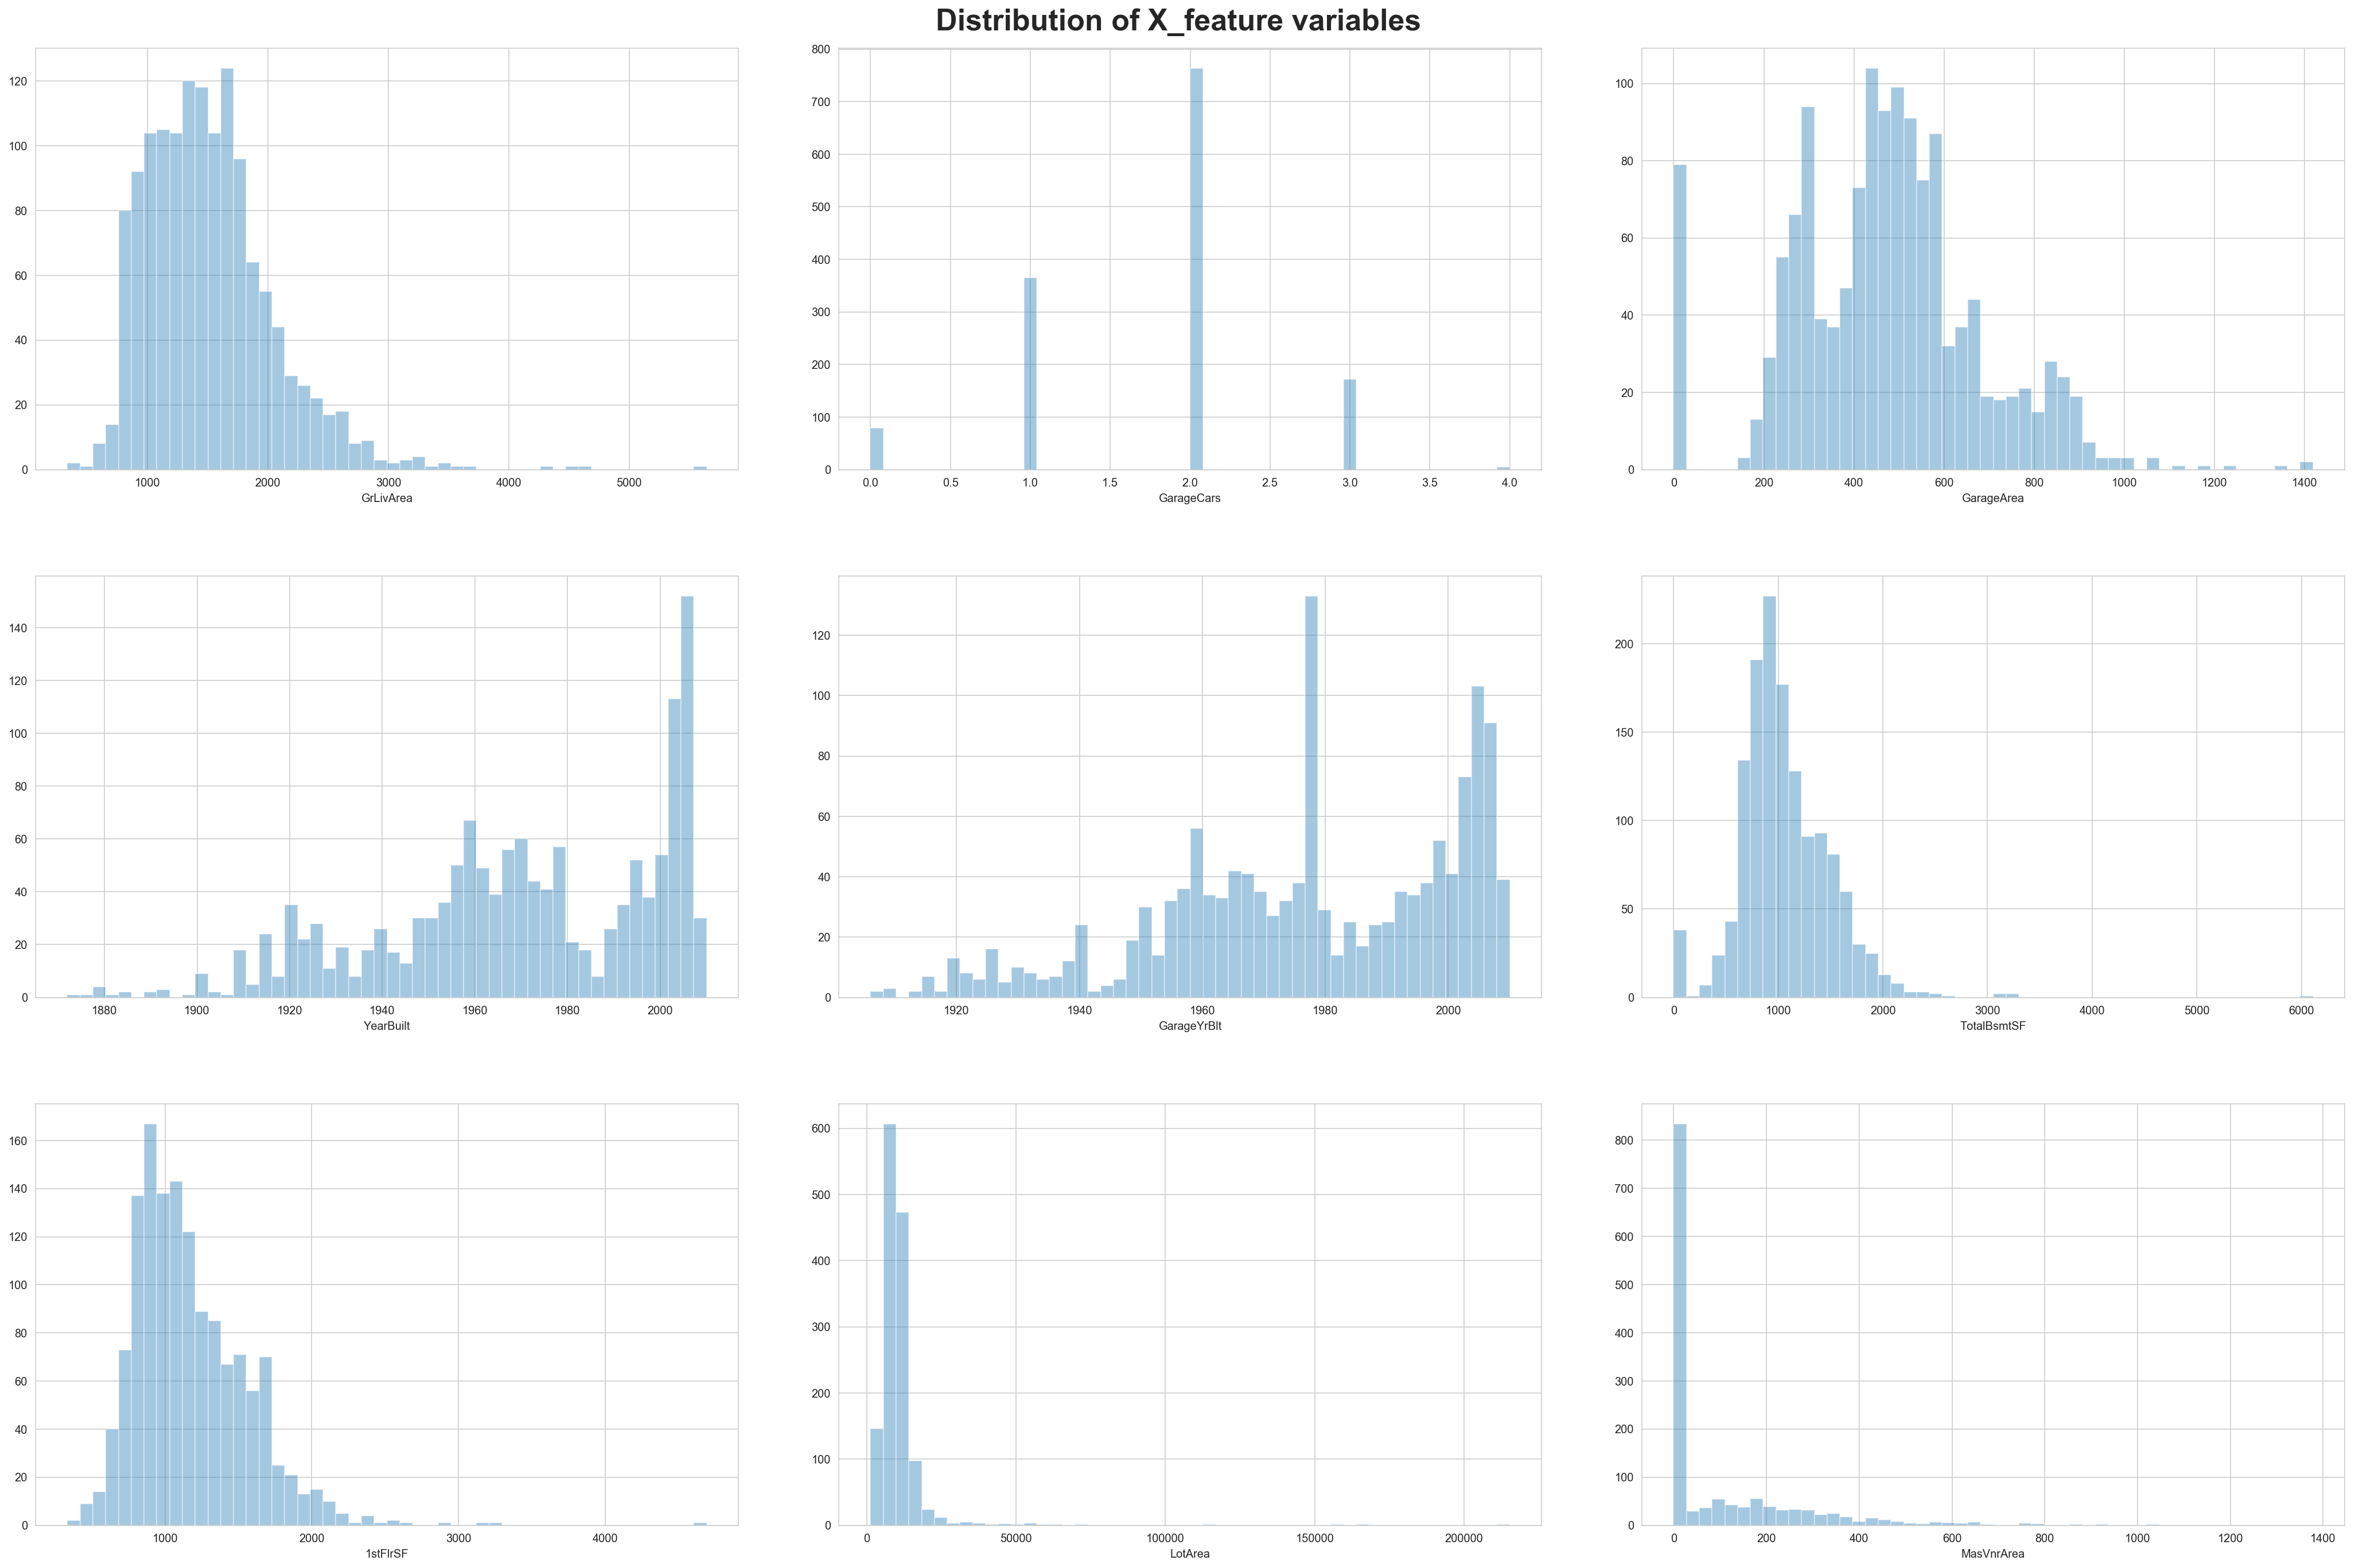

In [76]:
# check some of the more correlated X features

X_feature = df[['GrLivArea' ,'GarageCars','GarageArea','YearBuilt','GarageYrBlt', 'TotalBsmtSF','1stFlrSF','LotArea','MasVnrArea' ]] 

n_feat=X_feature.shape[1]
f, ax= plt.subplots(3,3,figsize=(30,20))
axes=ax.flatten()[:n_feat]
for i,ax in enumerate(axes):
    sns.distplot(X_feature.iloc[:,i],ax=ax,kde=False,bins=50)
    
f.suptitle('Distribution of X_feature variables',fontsize=26,fontweight='bold')
plt.tight_layout(pad=6)

# 'GrLivArea','1stFlrSF' and 'TotalBsmtSF' seems right skew.

In [77]:
#applying log transformation 'TotalBsmtSF'
df['GrLivArea'] = np.log(df['GrLivArea'])

df['1stFlrSF'] = np.log(df['1stFlrSF'])
# log transformation make right skew more normal distributed.

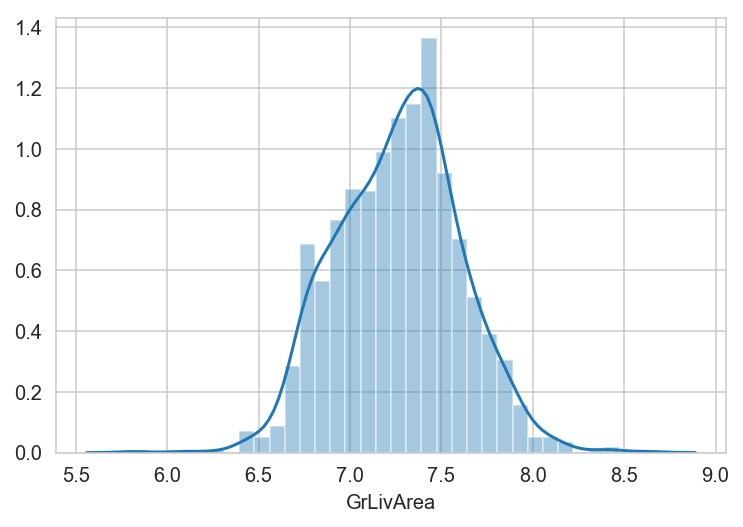

In [78]:
sns.distplot(df['GrLivArea'])


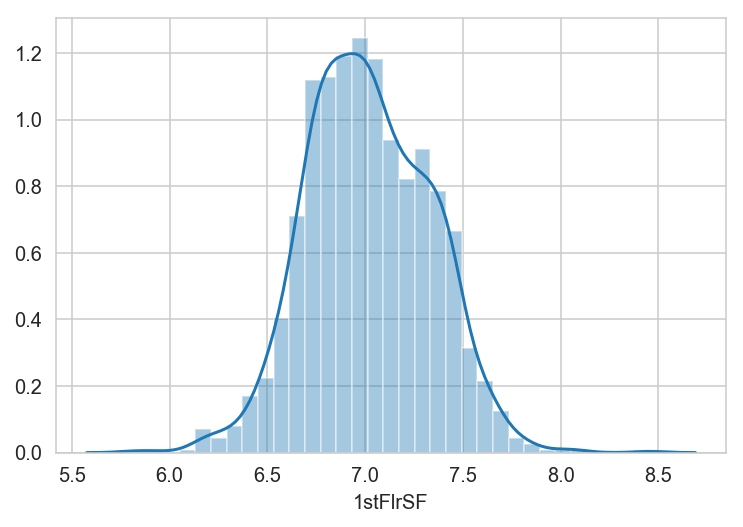

In [79]:
sns.distplot(df['1stFlrSF'])

In [80]:
df['TotalBsmtSF'].describe()

count    1385.000000
mean     1062.618773
std       443.785047
min         0.000000
25%       800.000000
50%       994.000000
75%      1306.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64


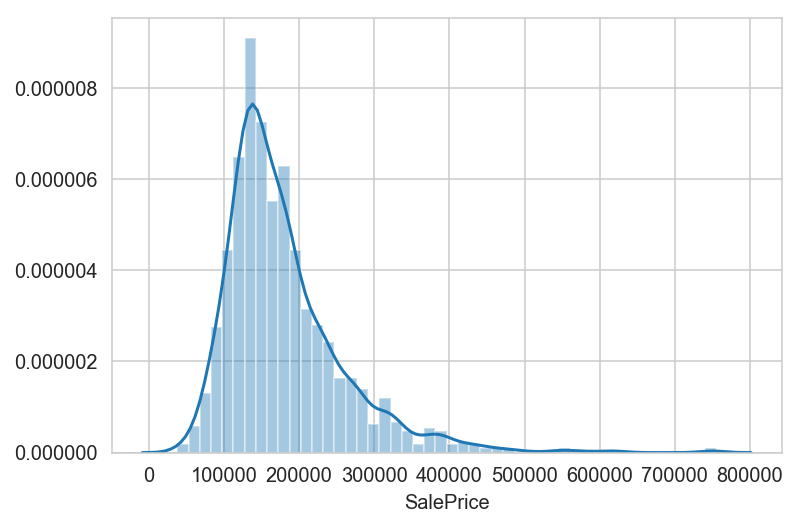

In [81]:
# take a look at target column
print(df['SalePrice'].describe())
sns.distplot(df['SalePrice'])

# minimun price is 37900 and Saleprice is right skew.

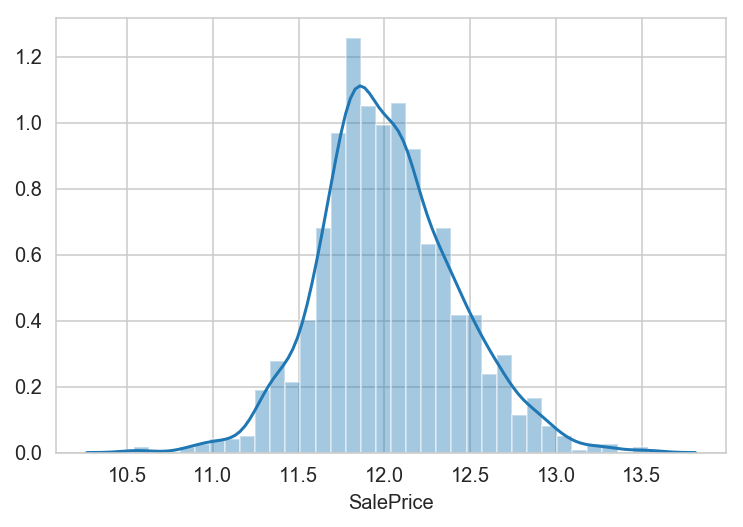

In [82]:
#applying log transformation
df['SalePrice'] = np.log(df['SalePrice'])

sns.distplot(df['SalePrice'])
# log transformation make right skew more normal distributed.

In [83]:
#4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
df['YrSold'].value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64

# 1d. Train a model on pre-2010 data 
and evaluate its performance on the 2010 houses

In [84]:
# create train y and x
cols = list(df.columns)
cols.remove('SalePrice')
fixed_col= [c for c in cols if c not in nonfixed_feature]

X = df[fixed_col]
# convert dummy dummy-coded variables
X = pd.get_dummies(X,drop_first=True) 

X_train = X[df['YrSold'].isin(['2006','2007','2008', '2009'])]
y_train = df['SalePrice'][df['YrSold'].isin(['2006','2007','2008', '2009'])]

X_test = X[df['YrSold'].isin(['2010'])]
y_test = df['SalePrice'][df['YrSold'].isin(['2010'])]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.columns)

(1221, 133)
(1221,)
(164, 133)
(164,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'BsmtQual_Gd', 'BsmtQual_TA', 'GarageType_2Types', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'PavedDrive_P', 'PavedDrive_Y'],
      dtype='object', length=133)


In [85]:
# standardize the predictor columns
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)


In [86]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fit a linear regression on the training set
lr = LinearRegression()
lr1 = LinearRegression().fit(Xs_train, y_train)

train_scores = cross_val_score(lr, Xs_train, y_train, cv=10) 
test_scores = lr1.score(Xs_test, y_test)
print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# linear regression perform poorly for predicting the test set.

train scores: [-1.49221359e+19 -3.49798214e+17  8.62355309e-01 -1.04424329e+26
 -1.46299599e+22  7.05645437e-01 -2.02051592e+24  8.41828667e-01
 -2.27979598e+23 -3.04560563e+14]
test scores: -1.9656673940216253e+22
Mean train scores: -1.066874699741408e+25
Mean test scores: -1.9656673940216253e+22


In [88]:
# Find an optimal alpha value and Cross-validate ridge regression
#Return numbers spaced evenly on a log scale.
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_ridge.alpha_)

ridge = Ridge(alpha=optimal_ridge.alpha_)

train_scores = cross_val_score(ridge, Xs_train, y_train, cv=10)

test_scores = optimal_ridge.score(Xs_test, y_test)

y_pred = optimal_ridge.predict(Xs_test)

print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = abs(np.e**(y_test)-np.e**(y_pred))
print("Mean residuals:", residuals.mean())

best alpha parameter: 390.6939937054621
train scores: [0.90058257 0.84171156 0.86785267 0.7945981  0.83719754 0.80733016
 0.82127385 0.85467555 0.68107396 0.82821015]
test scores: 0.8807332569803027
Mean train scores: 0.823450610238222
Mean test scores: 0.8807332569803027
Mean residuals: 17676.691398548206


In [89]:
optimal_ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_ridge.coef_,
                            'abs_coef':np.abs(optimal_ridge.coef_)})

optimal_ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_ridge_coefs.head(10))

                 variable      coef  abs_coef
12              GrLivArea  0.072939  0.072939
10               2ndFlrSF  0.047386  0.047386
9                1stFlrSF  0.042779  0.042779
14             GarageCars  0.039114  0.039114
121           BsmtQual_Ex  0.028526  0.028526
15             GarageArea  0.028431  0.028431
47   Neighborhood_NridgHt  0.028323  0.028323
8             TotalBsmtSF  0.025004  0.025004
5              BsmtFinSF1  0.024811  0.024811
37   Neighborhood_Crawfor  0.023540  0.023540


In [92]:
# lasso model
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)

train_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

test_scores = optimal_lasso.score(Xs_test, y_test)

y_pred = optimal_lasso.predict(Xs_test)

print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = abs(np.e**(y_test)-np.e**(y_pred))
print("Mean residuals:", residuals.mean())

# lasso perform better than ridge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

best alpha parameter: 0.003851087566804062
train scores: [0.89335092 0.85324355 0.86785041 0.8036508  0.8445924  0.78832759
 0.81408537 0.83909698 0.62668087 0.8427503 ]
test scores: 0.883426509164114
Mean train scores: 0.8173629199809312
Mean test scores: 0.883426509164114
Mean residuals: 17965.98521493151


In [91]:
optimal_lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

optimal_lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_lasso_coefs.head(10))

print('Percent variables zeroed out:', (np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_)))*100,"%")
# 40% of the variables zero out. dropping poorly related features gave better score

                 variable      coef  abs_coef
12              GrLivArea  0.146879  0.146879
3               YearBuilt  0.055677  0.055677
14             GarageCars  0.052048  0.052048
47   Neighborhood_NridgHt  0.037466  0.037466
121           BsmtQual_Ex  0.037002  0.037002
5              BsmtFinSF1  0.035900  0.035900
37   Neighborhood_Crawfor  0.028852  0.028852
9                1stFlrSF  0.026903  0.026903
53   Neighborhood_StoneBr  0.022391  0.022391
118       Foundation_Slab -0.022297  0.022297
Percent variables zeroed out: 40.6015037593985 %


In [96]:
# Find an optimal alpha value and cross-validate elastic net regression

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

train_scores = cross_val_score(enet, Xs_train, y_train, cv=10)
test_scores = optimal_enet.score(Xs_test, y_test)

y_pred = optimal_enet.predict(Xs_test)

print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = abs(np.e**(y_test)-np.e**(y_pred))
print("Mean residuals:", residuals.mean())
# ridge is mostly choosen.


best alpha parameter: 0.19450067090756665
optimal l1_ratio: 0.01
train scores: [0.90122178 0.85290421 0.86828803 0.79953469 0.84198407 0.80442523
 0.82440443 0.85143962 0.66337945 0.83402506]
test scores: 0.8828815222330204
Mean train scores: 0.8241606560900466
Mean test scores: 0.8828815222330204
0.8828815222330204
Mean residuals: 17649.598851640876


In [94]:
optimal_enet_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_enet.coef_,
                            'abs_coef':np.abs(optimal_enet.coef_)})

optimal_enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_enet_coefs.head(10))

print('Percent variables zeroed out:', (np.sum((optimal_enet.coef_ == 0))/float(len(optimal_enet.coef_)))*100,"%")
# 19.5% of the variables zero out.

                 variable      coef  abs_coef
12              GrLivArea  0.081535  0.081535
10               2ndFlrSF  0.047862  0.047862
9                1stFlrSF  0.046292  0.046292
14             GarageCars  0.041670  0.041670
121           BsmtQual_Ex  0.030244  0.030244
47   Neighborhood_NridgHt  0.030159  0.030159
3               YearBuilt  0.028436  0.028436
5              BsmtFinSF1  0.026751  0.026751
15             GarageArea  0.026292  0.026292
37   Neighborhood_Crawfor  0.024449  0.024449
Percent variables zeroed out: 19.548872180451127 %


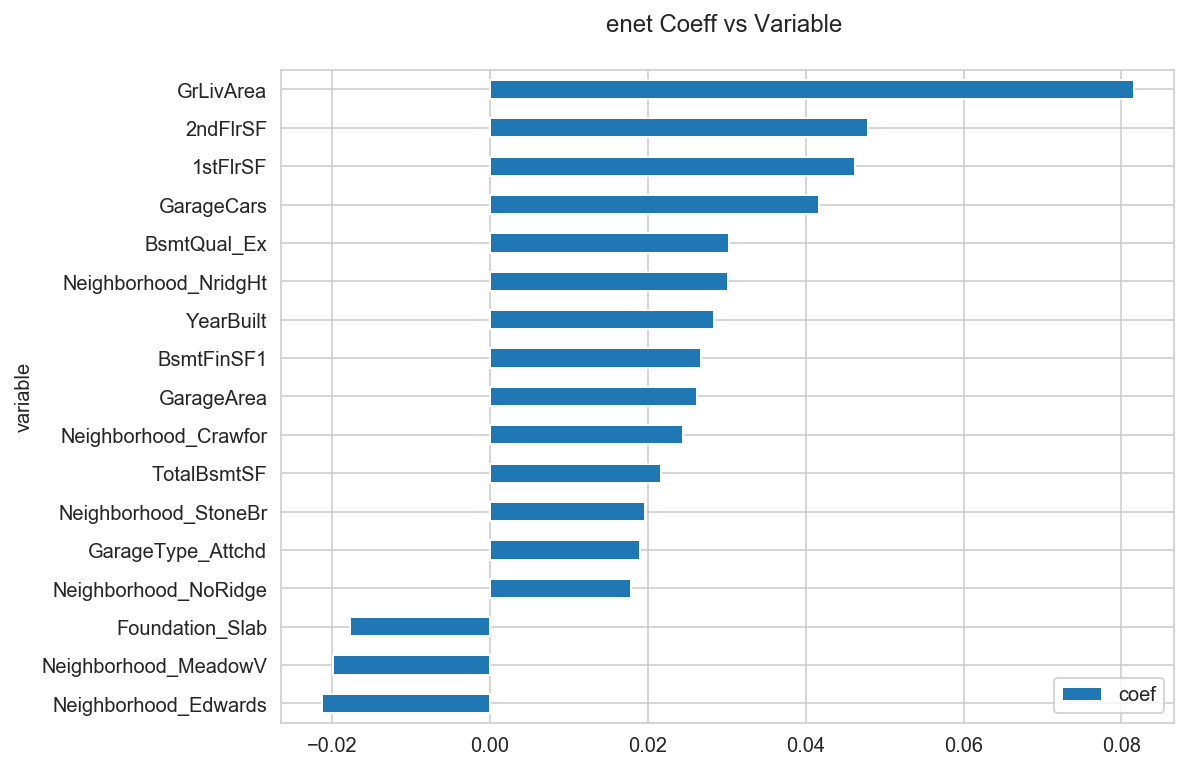

In [95]:
enet_coefs2 = optimal_enet_coefs[['variable','coef']]
enet_coefs2.set_index('variable',inplace=True)
enet_coefs2
enet_coefs2.head(17).sort_values('coef').plot(
    kind='barh', title='enet Coeff vs Variable \n', figsize=(8,6))
plt.legend(loc='lower right')
plt.show()

# 1e. Characterize your model. 
How well does it perform? What are the best estimates of price?
- Enet, lasso and ridge has almost same score of 0.88
- Features that affect the price most:

GrLivArea: Above grade (ground) living area square feet

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

GarageCars: Size of garage in car capacity

BsmtQual: Evaluates the height of the basement, Ex	Excellent (100+ inches)

Neighborhood_NridgHt

YearBuilt: Original construction date


- In general, larger the place, the more expensive it will be.
- Houses in Neighborhood NridgHt get higher price.
- Newly built houses are more expensive

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# 2a. Evaluate the effect in dollars of the renovate-able features.

In [98]:
# create a price_var column

cols = list(df.columns)
cols.remove('SalePrice')
fixed_col= [c for c in cols if c not in nonfixed_feature]

X = df[fixed_col]
# convert dummy dummy-coded variables
X = pd.get_dummies(X,drop_first=True) 

X_train = X[df['YrSold'].isin(['2006','2007','2008', '2009'])]
y_train = df['SalePrice'][df['YrSold'].isin(['2006','2007','2008', '2009'])]

y = df['SalePrice']

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs = ss.fit_transform(X)

# find residuals of 1st model 
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

train_scores = cross_val_score(enet, Xs_train, y_train, cv=10)
scores = optimal_enet.score(Xs, y)

y_pred = optimal_enet.predict(Xs)

print("train scores:", train_scores)
print("scores:", scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = np.e**(y)-np.e**(y_pred)
print("Mean residuals:", residuals.mean())

#on average, real y is more than predicted y.

best alpha parameter: 0.19450067090756665
optimal l1_ratio: 0.01
train scores: [0.90122178 0.85290421 0.86828803 0.79953469 0.84198407 0.80442523
 0.82440443 0.85143962 0.66337945 0.83402506]
scores: 0.8716299892442442
Mean train scores: 0.8241606560900466
Mean test scores: 0.8716299892442442
Mean residuals: 2760.6644130982427


In [99]:
# create a price_var column
print(len(residuals))
df['price_var']=residuals
print(df['price_var'].head())

1385
0     2274.364513
1     8293.712554
2    10698.502360
3   -50080.184914
4   -33529.862966
Name: price_var, dtype: float64


count      1385.000000
mean       2760.664413
std       29780.943817
min     -462175.191127
25%      -11110.573600
50%         952.825791
75%       12581.027770
max      210124.307712
Name: price_var, dtype: float64


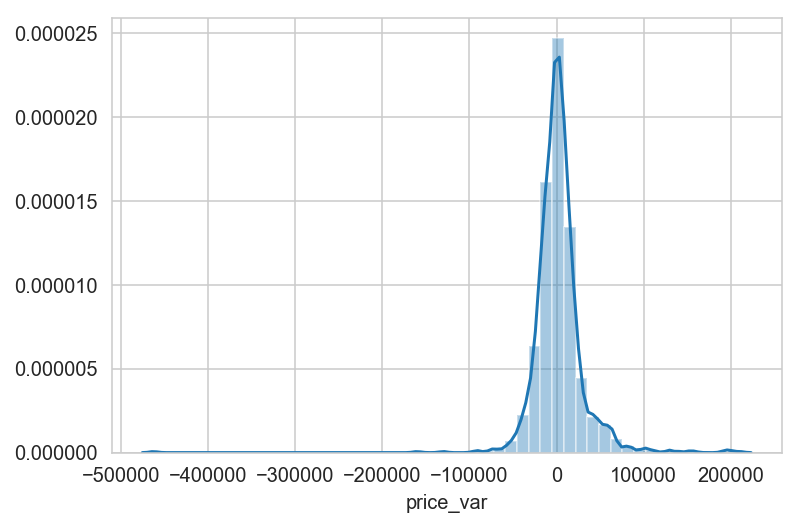

In [100]:
# take a look at target column
print(df['price_var'].describe())
sns.distplot(df['price_var'])

In [101]:
# remove outliers 
print(df.shape)
var_df=df[(df['price_var'] < 70000) & (df['price_var']> -70000)] 

print(var_df.shape)

print('percentage outliers removed', ((df.shape[0]-var_df.shape[0])/df.shape[0])*100)

(1385, 82)
(1353, 82)
percentage outliers removed 2.3104693140794224


count     1353.000000
mean      1566.059464
std      20366.129989
min     -68916.907583
25%     -11110.573600
50%        807.618286
75%      11847.499647
max      69059.862782
Name: price_var, dtype: float64


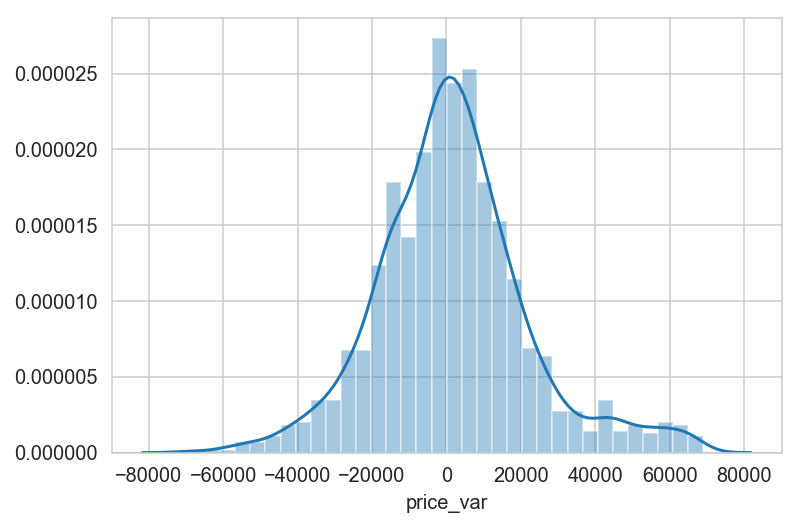

In [102]:
print(var_df['price_var'].describe())
sns.distplot(var_df['price_var'])


In [103]:
# check correlation
var_df.corr('spearman').abs()[['price_var']].sort_values(by='price_var', ascending=False).head(20)

,price_var
price_var,1.000000
SalePrice,0.373663
OverallCond,0.339055
OverallQual,0.260579
YearRemodAdd,0.220875
Fireplaces,0.201663
BsmtFullBath,0.149873
LotArea,0.148801
OpenPorchSF,0.147558
BsmtFinSF1,0.145076


In [104]:
#check renovate-able features
print(nonfixed_feature)

['Id', 'LandSlope', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


In [105]:
#remove some features

nonfixed_feature = ['HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']

print(nonfixed_feature)

['HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']


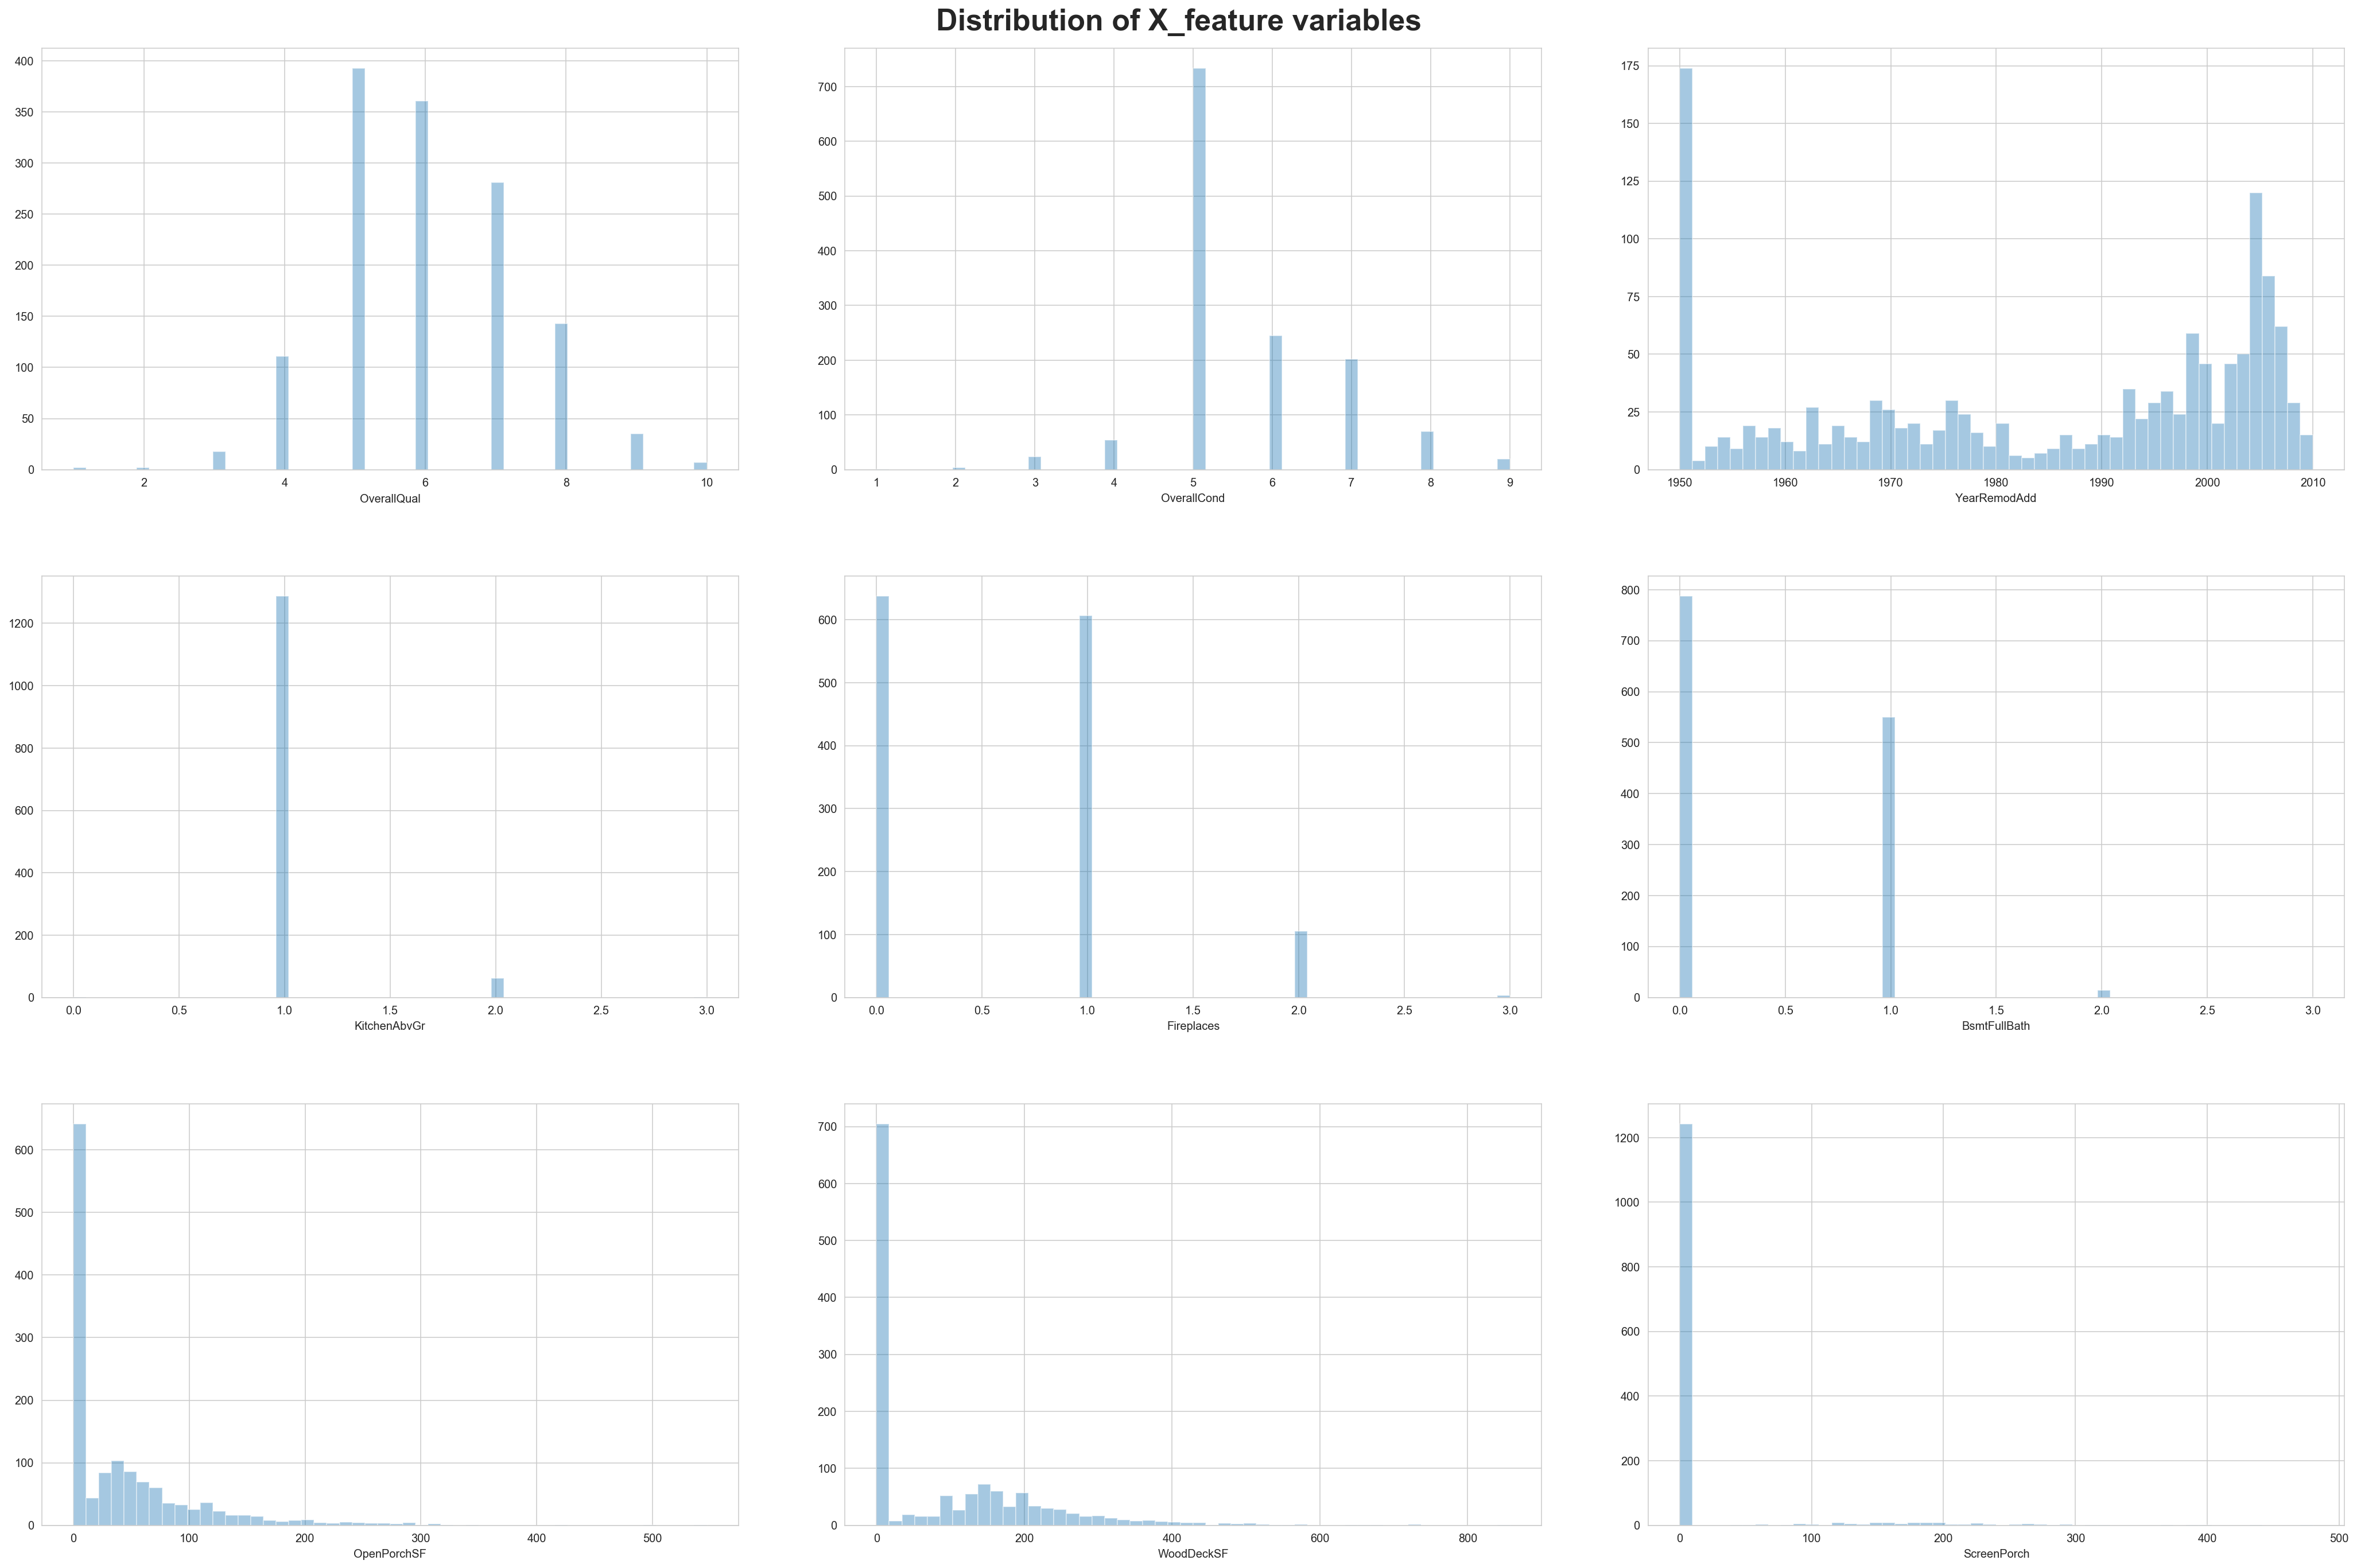

In [106]:
# check some of the more corelated featured
X_feature = var_df[['OverallQual', 'OverallCond', 'YearRemodAdd', 
        'KitchenAbvGr', 'Fireplaces', 
       'BsmtFullBath','OpenPorchSF', 'WoodDeckSF','ScreenPorch']] 

n_feat=X_feature.shape[1]
f, ax= plt.subplots(3,3,figsize=(30,20))
axes=ax.flatten()[:n_feat]
for i,ax in enumerate(axes):
    sns.distplot(X_feature.iloc[:,i],ax=ax,kde=False,bins=50)
    
f.suptitle('Distribution of X_feature variables',fontsize=26,fontweight='bold')
plt.tight_layout(pad=6)

# seems ok

In [107]:
# create predictors 

X = var_df[nonfixed_feature]

# convert dummy dummy-coded variables
X = pd.get_dummies(X,drop_first=True) 

X_train = X[var_df['YrSold'].isin(['2006','2007','2008', '2009'])]
y_train = var_df['price_var'][var_df['YrSold'].isin(['2006','2007','2008', '2009'])]

X_test = X[var_df['YrSold'].isin(['2010'])]
y_test = var_df['price_var'][var_df['YrSold'].isin(['2010'])]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.columns)

(1191, 104)
(1191,)
(162, 104)
(162,)
Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd',
       ...
       'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv',
       'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC'],
      dtype='object', length=104)


In [108]:
# standardize the predictor columns
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

lr = LinearRegression()
lr1 = LinearRegression().fit(Xs_train, y_train)

train_scores = cross_val_score(lr, Xs_train, y_train, cv=10) 
test_scores = lr1.score(Xs_test, y_test)
print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# linear regression perform poorly.

train scores: [-1.27387098e-02 -3.42433467e+23 -4.75216809e+19  3.45547740e-01
 -1.59358560e+12 -1.85686013e+20 -6.16305471e+21  2.37019093e-01
 -3.85814860e+26 -1.47839275e+23]
test scores: -3.3536179957079724e+16
Mean train scores: -3.8631152862053555e+25
Mean test scores: -3.3536179957079724e+16


In [109]:
# Find an optimal alpha value and Cross-validate ridge regression
#Return numbers spaced evenly on a log scale.
ridge_alphas = np.logspace(-2, 7, 50)

kf_shuffle = KFold(n_splits=10,shuffle=True)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=kf_shuffle)
optimal_ridge.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_ridge.alpha_)

ridge = Ridge(alpha=optimal_ridge.alpha_)

train_scores = cross_val_score(ridge, Xs_train, y_train, cv=kf_shuffle)

test_scores = optimal_ridge.score(Xs_test, y_test)

y_pred = optimal_ridge.predict(Xs_test)

# revert back the log transformation
residuals = abs((y_test)-(y_pred))

print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))
# on average our prediction is off by this amount.
print("Mean residuals:", residuals.mean())

# ridge perform poorly for predicting the test set.

best alpha parameter: 167.683293681101
train scores: [ 0.25506226  0.25757393  0.24040694  0.24225799  0.30511843  0.29958843
 -0.13108973  0.38086327  0.29309943  0.27158477]
test scores: 0.28512353546208047
Mean train scores: 0.24144657036365175
Mean test scores: 0.28512353546208047
Mean residuals: 13304.784376140202


In [117]:
optimal_ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_ridge.coef_,
                            'abs_coef':np.abs(optimal_ridge.coef_)})

optimal_ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_ridge_coefs.head(13))

           variable         coef     abs_coef
1       OverallCond  5912.122184  5912.122184
0       OverallQual  3248.440846  3248.440846
67   KitchenQual_Gd -2254.178114  2254.178114
10       Fireplaces  2092.926305  2092.926305
37  BsmtExposure_Gd  1928.084785  1928.084785
68   KitchenQual_TA -1891.694234  1891.694234
2      YearRemodAdd  1568.798123  1568.798123
53     Heating_GasW  1530.330724  1530.330724
74   Functional_Typ  1512.999831  1512.999831
12      OpenPorchSF  1412.813794  1412.813794
8      KitchenAbvGr -1293.408988  1293.408988
39  BsmtExposure_No -1182.491173  1182.491173
26     ExterQual_Gd -1141.535025  1141.535025


In [111]:
# lasso model
kf_shuffle = KFold(n_splits=10,shuffle=True)
optimal_lasso = LassoCV(n_alphas=500, cv=kf_shuffle, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)

train_scores = cross_val_score(lasso, Xs_train, y_train, cv=kf_shuffle)
test_scores = optimal_lasso.score(Xs_test, y_test)

y_pred = optimal_lasso.predict(Xs_test)
print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = abs((y_test)-(y_pred))
print("Mean residuals:", residuals.mean())

# lasso has similar score as ridge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

best alpha parameter: 287.4210114336542
train scores: [0.17247919 0.20707354 0.36175881 0.33490353 0.22012572 0.24200796
 0.29528682 0.23893916 0.30429822 0.2200967 ]
test scores: 0.2930716229485566
Mean train scores: 0.2596969642073451
Mean test scores: 0.2930716229485566
Mean residuals: 13225.37847041084


In [116]:
optimal_lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

optimal_lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_lasso_coefs.head(13))

print('Percent variables zeroed out:', (np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_)))*100,"%")
# 41% of the variables zero out.

           variable         coef     abs_coef
1       OverallCond  6655.143948  6655.143948
0       OverallQual  4103.601788  4103.601788
10       Fireplaces  2407.936885  2407.936885
67   KitchenQual_Gd -2257.803754  2257.803754
37  BsmtExposure_Gd  2032.504841  2032.504841
68   KitchenQual_TA -1709.836692  1709.836692
53     Heating_GasW  1405.394136  1405.394136
74   Functional_Typ  1367.651088  1367.651088
12      OpenPorchSF  1299.268010  1299.268010
2      YearRemodAdd  1098.653119  1098.653119
3      BsmtFullBath   987.631049   987.631049
39  BsmtExposure_No  -965.007381   965.007381
73   Functional_Sev  -871.540293   871.540293
Percent variables zeroed out: 41.34615384615385 %


In [113]:
# Find an optimal alpha value and cross-validate elastic net regression
kf_shuffle = KFold(n_splits=10,shuffle=True)
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=kf_shuffle)
optimal_enet.fit(Xs_train, y_train)

print("best alpha parameter:", optimal_enet.alpha_)
print("optimal l1_ratio:", optimal_enet.l1_ratio_) #(0 = all ridge, 1 = all lasso)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

train_scores = cross_val_score(enet, Xs_train, y_train, cv=kf_shuffle)
test_scores = optimal_enet.score(Xs_test, y_test)

y_pred = optimal_enet.predict(Xs_test)

print("train scores:", train_scores)
print("test scores:", test_scores)
print("Mean train scores:", np.mean(train_scores))
print("Mean test scores:", np.mean(test_scores))

# on average our prediction is off by this amount.
# revert back the log transformation
residuals = abs(y_test)-(y_pred)
print("Mean residuals:", residuals.mean())
# only lasso is choosen.
# mean test score is worse than ridge

best alpha parameter: 292.6822182759371
optimal l1_ratio: 1.0
train scores: [0.25500498 0.30403742 0.28371454 0.16788955 0.34932869 0.27649263
 0.2971633  0.24629558 0.26235516 0.30771966]
test scores: 0.29270947556496607
Mean train scores: 0.27500014994742666
Mean test scores: 0.29270947556496607
Mean residuals: 14909.237445149654


In [118]:
optimal_enet_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':optimal_enet.coef_,
                            'abs_coef':np.abs(optimal_enet.coef_)})

optimal_enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(optimal_enet_coefs.head(13))

print('Percent variables zeroed out:', (np.sum((optimal_enet.coef_ == 0))/float(len(optimal_enet.coef_)))*100,"%")
# 55% of the variables zero out.

           variable         coef     abs_coef
1       OverallCond  6650.672973  6650.672973
0       OverallQual  4106.941716  4106.941716
10       Fireplaces  2398.194043  2398.194043
67   KitchenQual_Gd -2205.485104  2205.485104
37  BsmtExposure_Gd  2031.355983  2031.355983
68   KitchenQual_TA -1651.968065  1651.968065
53     Heating_GasW  1396.681212  1396.681212
74   Functional_Typ  1368.214879  1368.214879
12      OpenPorchSF  1295.213280  1295.213280
2      YearRemodAdd  1090.778621  1090.778621
3      BsmtFullBath   989.576629   989.576629
39  BsmtExposure_No  -956.001639   956.001639
73   Functional_Sev  -866.164943   866.164943
Percent variables zeroed out: 41.34615384615385 %


# Evaluate the effect in dollars of the renovate-able features
    
- Ridge, lasso and enet about the same score.
- Features that affect the price most in enet model:

1       OverallCond  6650.672973  
0       OverallQual  4106.941716  
10       Fireplaces  2398.194043  
67   KitchenQual_Gd -2205.485104  
37  BsmtExposure_Gd  2031.355983  
68   KitchenQual_TA -1651.968065  
53     Heating_GasW  1396.681212  
74   Functional_Typ  1368.214879  
12      OpenPorchSF  1295.213280  
2      YearRemodAdd  1090.778621  
3      BsmtFullBath   989.576629
39  BsmtExposure_No  -956.001639
73   Functional_Sev  -866.164943 

- positive predictors:

OverallCond: Rates the overall condition of the house

OverallQual: Rates the overall material and finish of the house

BsmtExposure: Refers to walkout or garden level walls, Gd	Good Exposure

Fireplaces: Number of fireplaces

Functional: Home functionality (Assume typical unless deductions are warranted), Typ	Typical Functionality

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

Heating_GasW: Heating GasW - Gas hot water or steam heat

OpenPorchSF: Open porch area in square feet

BsmtFullBath: Basement full bathrooms

- negative predictors:

KitchenQual: Kitchen quality, TA	Typical/Average, Gd good

Functional: Home functionality (Assume typical unless deductions are warranted), Sev	Severely Damaged

BsmtExposure_No: Refers to walkout or garden level walls, No Exposure

# 2b. How would your company use this second model 
and its coefficients to determine whether they should buy a property or not? 
Explain how the company can use the two models you have built to determine if they can make money. 

- Company can renovate the house to have better overall condition, overall material and finish, good basement exposure, renovate-able features such as fireplaces and heating GasW. Make sure the home have typical functionality. From Remodel date, we can infer that a remodel house will fetch higher price.
The company just need to make sure that the renovation cost is less than the increase in selling price, so to make a profit.
- Company should avoid having Typical or good Kitchen quality and quality of the material on the exterior, so renovate these quality to be excellent. Avoid Severely Damaged Home functionality.

- Using the two models:

1) company should buy houses of good quality that is below the price that we predicted. 

2) Company can also buy houses of poor quality and renovate it to be of a overall good condition and quality. Then sell the houses off at a higher price to make money.

3) The best scenario will be the company buy a cheap large house of poor quality and renovate it. Then sell it off for a large profit margin by advertising the newly renovated features and the large space of the house.

# 2c. how features affect variance in price 
Investigate how much of the variance in price remaining is explained by these features.

residuals of model1 = (y_test - y_pred) of model1 
if residual is positive, real y values is more than predicted value. 
So we can probably sell at a higher price if residual is positive. 

1       OverallCond  6650.672973  
0       OverallQual  4106.941716  
10       Fireplaces  2398.194043  
67   KitchenQual_Gd -2205.485104  
37  BsmtExposure_Gd  2031.355983  
68   KitchenQual_TA -1651.968065  
53     Heating_GasW  1396.681212  
74   Functional_Typ  1368.214879  
12      OpenPorchSF  1295.213280  
2      YearRemodAdd  1090.778621  
3      BsmtFullBath   989.576629
39  BsmtExposure_No  -956.001639
73   Functional_Sev  -866.164943 

positive: 
- With every increase in grade of overall condition of the house, the residual goes up by $6650

- With every increase in grade of overall material and finish of the house, the residual goes up by $4106

- Having good basement exposure increase residual by $2031

- Having renovate-able features such as fireplaces increase residual by about $2398 .

- Typical home Functionality increase residual by  $1368

negative: 

- Good Kitchen quality will decrease the residual by - $2205

- Typical Kitchen quality will decrease the residual by - $1651  

- Severely Damaged Home functionality decrease the residual by -$866



# 2d. Do you trust your model? 
Should it be used to evaluate which properties to buy and fix up?

- The 1st enet model1 on the fixed features has quite a good score of 0.87. It should be use as a guide to buy houses that are priced below the predicted values.
- The current 2nd ridge model2 has a Mean test scores of only 0.28, so it is a poor predictor of the variance of model1 and it can only be used as a rough gauge to see which are the possible renovatable features. 
- For model2, I can perform better EDA, select the better predictor features, perform features engineering and test other models. 
- After that then the model can be trusted and it can be used determine which renovation to do and how much the features will increase the sales price of the house. This will in turn be use to estimate how much renovation cost could spend in order to maximise profit from the house sale.